In [1]:
from torch import nn, optim, float32, randn, LongTensor, uint8
import torch
import torch.nn.functional as F
from dataset.chestxray import ChestXRayDataset
from datahandling.dataloader import get_list_from_txt, extract_annotation_targets, extract_unique_labels
from datahandling.transforms import to_numeric_label
from torch.utils.data import DataLoader
from torchvision import datasets, models
import torchvision.transforms as transforms
import os
import ast
import pandas as pd
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
from dotenv import  load_dotenv
from diffusers import DDPMScheduler, DDPMPipeline
import timeit

/cluster/home/larsira/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Environment Variables

In [2]:
load_dotenv()
debug = ast.literal_eval(os.getenv("DEBUG"))
db_path = os.getenv("DB_PATH")
img_dir_name = os.getenv("IMG_DIR")
class_file_name = os.getenv("CLASSIFICATION_FILE")
train_list = os.getenv("TRAIN_VAL_LIST")
test_list = os.getenv("TEST_LIST")

device="cpu"
if torch.cuda.is_available():
    device="cuda"

print(device, test_list)

cuda test_list.txt


# Set Constants

In [13]:
NUM_TRAIN_TIMESTEPS = 1000
IMG_SIZE = 128
NUM_GENERATE_IMAGES = 9
BATCH_SIZE = 16
WARMUP_STEPS = 100
NUM_EPOCHS = 100
LEARNING_RATE= 1e-4
MIXED_PRECISION = "fp16"
GRADIENT_ACCUMULATION_STEPS = 1
RANDOM_SEED = 1
NUM_TIMESTEPS = 100

# Load data

In [4]:
img_dir = os.path.join(db_path, img_dir_name)
annotations_file = os.path.join(db_path, class_file_name)
annotations = pd.read_csv(annotations_file)
annotations = annotations[annotations["Finding Labels"].str.contains("\|") == False].tail(500)
annotations.to_csv(os.path.join(db_path, "small_file.csv"), index=False)
annotations_file = os.path.join(db_path, "small_file.csv")
annotations = pd.read_csv(annotations_file)

preprocess_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5]),
])
print(annotations)
train_dataset = ChestXRayDataset(annotations_file, img_dir, transform=preprocess_transforms, read_lib="pil")
train_loader = DataLoader(train_dataset, BATCH_SIZE)

          Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
0    00030520_000.png     No Finding            0       30520           45   
1    00030521_000.png     No Finding            0       30521           55   
2    00030521_001.png     No Finding            1       30521           56   
3    00030522_001.png     No Finding            0       30522           26   
4    00030522_000.png     No Finding            1       30522           26   
..                ...            ...          ...         ...          ...   
495  00030801_000.png     No Finding            0       30801           38   
496  00030802_000.png     No Finding            0       30802           28   
497  00030803_000.png     No Finding            0       30803           42   
498  00030804_000.png     No Finding            0       30804           29   
499  00030805_000.png     No Finding            0       30805           26   

    Patient Gender View Position  OriginalImage[Width  Height] 

# Define Noise Scheduler

In [5]:
# https://huggingface.co/docs/diffusers/tutorials/basic_training#create-a-scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TRAIN_TIMESTEPS)

def schedule_noise(image):
    noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TRAIN_TIMESTEPS)
    noise = randn(image.shape)
    timesteps = LongTensor([50])
    noisy_image = noise_scheduler.add_noise(image, noise, timesteps)
    return noisy_image

# Test Scheduler

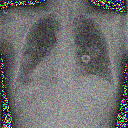

In [11]:
image = next(iter(train_loader))[0]
noised_image = schedule_noise(image)
Image.fromarray(((noised_image.permute(0,2,3,1)+1.0) * 127.5).type(uint8).numpy()[0])

# Define Model

In [7]:
from diffusers import UNet2DModel
model = UNet2DModel(
    sample_size = IMG_SIZE,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512, 512),
   down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [8]:
sample_image = train_dataset[0][0].unsqueeze(0)

print("Input shape:", sample_image.shape)
print("Output shape:", model(sample_image, timestep=0).sample.shape)

Input shape: torch.Size([1, 3, 128, 128])
Output shape: torch.Size([1, 3, 128, 128])


# Optimizers

In [9]:
# Partially based on HuggingFace implementation: https://github.com/huggingface/diffusers/blob/v0.26.3/src/diffusers/pipelines/ddim/pipeline_ddim.py#L49
def sample_image_generation(model, noise_scheduler, num_generate_images, random_seed, num_timesteps):
    pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
    
    images = pipeline(
        batch_size=num_generate_images,
        generator=torch.manual_seed(random_seed),
        num_inference_steps=num_timesteps
    ).images
    
    fig = plt.figure()
    for i in range(1, num_generate_images+1):
        fig.add_subplot(3, 3, i)
        plt.imshow(images[i-1])
    plt.show()

100%|██████████| 32/32 [00:13<00:00,  2.40it/s]


------------------------------
train loss epoch: 1: 0.0731
Train Learning Rate EPOCH: 1: 3.2000000000000005e-05



100%|██████████| 100/100 [00:04<00:00, 24.15it/s]


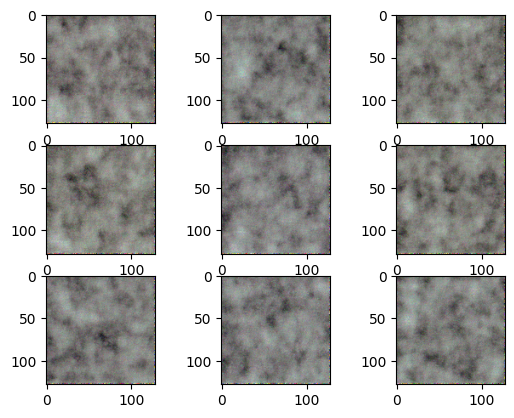

  1%|          | 1/100 [00:18<29:51, 18.09s/it]

------------------------------


  2%|▏         | 2/100 [00:31<24:56, 15.27s/it]

------------------------------
train loss epoch: 2: 0.0473
Train Learning Rate EPOCH: 2: 6.400000000000001e-05
------------------------------


  3%|▎         | 3/100 [00:44<23:16, 14.39s/it]

------------------------------
train loss epoch: 3: 0.0347
Train Learning Rate EPOCH: 3: 9.6e-05
------------------------------


  4%|▍         | 4/100 [00:58<22:19, 13.96s/it]

------------------------------
train loss epoch: 4: 0.0279
Train Learning Rate EPOCH: 4: 9.99798718764995e-05
------------------------------


  5%|▌         | 5/100 [01:11<21:40, 13.69s/it]

------------------------------
train loss epoch: 5: 0.0247
Train Learning Rate EPOCH: 5: 9.990759721625005e-05
------------------------------


  6%|▌         | 6/100 [01:24<21:08, 13.50s/it]

------------------------------
train loss epoch: 6: 0.0207
Train Learning Rate EPOCH: 6: 9.978284121609591e-05
------------------------------


  7%|▋         | 7/100 [01:37<20:44, 13.38s/it]

------------------------------
train loss epoch: 7: 0.0238
Train Learning Rate EPOCH: 7: 9.96057350657239e-05
------------------------------


  8%|▊         | 8/100 [01:50<20:26, 13.33s/it]

------------------------------
train loss epoch: 8: 0.0189
Train Learning Rate EPOCH: 8: 9.93764650046766e-05
------------------------------


  9%|▉         | 9/100 [02:03<20:06, 13.26s/it]

------------------------------
train loss epoch: 9: 0.0169
Train Learning Rate EPOCH: 9: 9.909527212650839e-05
------------------------------


 10%|█         | 10/100 [02:16<19:49, 13.22s/it]

------------------------------
train loss epoch: 10: 0.0146
Train Learning Rate EPOCH: 10: 9.876245212525871e-05
------------------------------


100%|██████████| 32/32 [00:13<00:00,  2.44it/s]


------------------------------
train loss epoch: 11: 0.0121
Train Learning Rate EPOCH: 11: 9.837835498450891e-05



100%|██████████| 100/100 [00:03<00:00, 25.02it/s][A


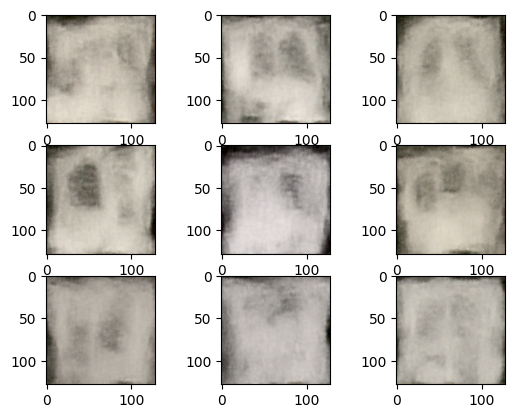

 11%|█         | 11/100 [02:34<21:39, 14.61s/it]

------------------------------


 12%|█▏        | 12/100 [02:47<20:45, 14.15s/it]

------------------------------
train loss epoch: 12: 0.0120
Train Learning Rate EPOCH: 12: 9.794338460935013e-05
------------------------------


 13%|█▎        | 13/100 [03:00<20:04, 13.84s/it]

------------------------------
train loss epoch: 13: 0.0122
Train Learning Rate EPOCH: 13: 9.74579984016486e-05
------------------------------


 14%|█▍        | 14/100 [03:14<19:31, 13.62s/it]

------------------------------
train loss epoch: 14: 0.0104
Train Learning Rate EPOCH: 14: 9.69227067790556e-05
------------------------------


 15%|█▌        | 15/100 [03:27<19:04, 13.47s/it]

------------------------------
train loss epoch: 15: 0.0114
Train Learning Rate EPOCH: 15: 9.633807263826744e-05
------------------------------


 16%|█▌        | 16/100 [03:40<18:42, 13.36s/it]

------------------------------
train loss epoch: 16: 0.0098
Train Learning Rate EPOCH: 16: 9.570471076310006e-05
------------------------------


 17%|█▋        | 17/100 [03:53<18:23, 13.29s/it]

------------------------------
train loss epoch: 17: 0.0146
Train Learning Rate EPOCH: 17: 9.502328717800082e-05
------------------------------


 18%|█▊        | 18/100 [04:06<18:05, 13.24s/it]

------------------------------
train loss epoch: 18: 0.0112
Train Learning Rate EPOCH: 18: 9.429451844767694e-05
------------------------------


 19%|█▉        | 19/100 [04:19<17:48, 13.20s/it]

------------------------------
train loss epoch: 19: 0.0096
Train Learning Rate EPOCH: 19: 9.351917092357755e-05
------------------------------


 20%|██        | 20/100 [04:32<17:33, 13.17s/it]

------------------------------
train loss epoch: 20: 0.0096
Train Learning Rate EPOCH: 20: 9.269805993802129e-05
------------------------------


100%|██████████| 32/32 [00:13<00:00,  2.44it/s]


------------------------------
train loss epoch: 21: 0.0081
Train Learning Rate EPOCH: 21: 9.18320489468172e-05



100%|██████████| 100/100 [00:03<00:00, 25.20it/s][A


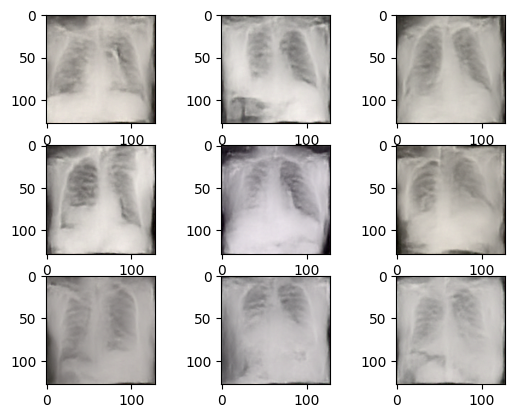

 21%|██        | 21/100 [04:50<19:13, 14.60s/it]

------------------------------


 22%|██▏       | 22/100 [05:03<18:23, 14.15s/it]

------------------------------
train loss epoch: 22: 0.0081
Train Learning Rate EPOCH: 22: 9.092204862128042e-05
------------------------------


 23%|██▎       | 23/100 [05:16<17:45, 13.84s/it]

------------------------------
train loss epoch: 23: 0.0093
Train Learning Rate EPOCH: 23: 8.996901589059729e-05
------------------------------


 24%|██▍       | 24/100 [05:30<17:15, 13.62s/it]

------------------------------
train loss epoch: 24: 0.0079
Train Learning Rate EPOCH: 24: 8.897395293554727e-05
------------------------------


 25%|██▌       | 25/100 [05:43<16:50, 13.47s/it]

------------------------------
train loss epoch: 25: 0.0093
Train Learning Rate EPOCH: 25: 8.793790613463955e-05
------------------------------


 26%|██▌       | 26/100 [05:56<16:29, 13.37s/it]

------------------------------
train loss epoch: 26: 0.0082
Train Learning Rate EPOCH: 26: 8.686196496377252e-05
------------------------------


 27%|██▋       | 27/100 [06:09<16:11, 13.30s/it]

------------------------------
train loss epoch: 27: 0.0112
Train Learning Rate EPOCH: 27: 8.574726085057357e-05
------------------------------


 28%|██▊       | 28/100 [06:22<15:54, 13.26s/it]

------------------------------
train loss epoch: 28: 0.0094
Train Learning Rate EPOCH: 28: 8.459496598462344e-05
------------------------------


 29%|██▉       | 29/100 [06:35<15:39, 13.23s/it]

------------------------------
train loss epoch: 29: 0.0097
Train Learning Rate EPOCH: 29: 8.340629208481674e-05
------------------------------


 30%|███       | 30/100 [06:48<15:24, 13.20s/it]

------------------------------
train loss epoch: 30: 0.0088
Train Learning Rate EPOCH: 30: 8.218248912515442e-05
------------------------------


100%|██████████| 32/32 [00:13<00:00,  2.44it/s]


------------------------------
train loss epoch: 31: 0.0073
Train Learning Rate EPOCH: 31: 8.092484402030853e-05



100%|██████████| 100/100 [00:03<00:00, 25.15it/s][A


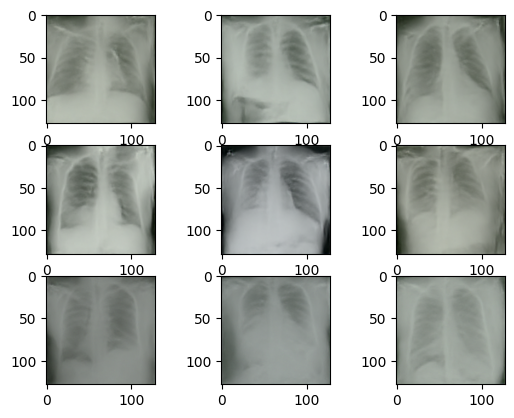

 31%|███       | 31/100 [07:06<16:45, 14.57s/it]

------------------------------


 32%|███▏      | 32/100 [07:19<16:01, 14.14s/it]

------------------------------
train loss epoch: 32: 0.0071
Train Learning Rate EPOCH: 32: 7.963467927234103e-05
------------------------------


 33%|███▎      | 33/100 [07:32<15:27, 13.84s/it]

------------------------------
train loss epoch: 33: 0.0079
Train Learning Rate EPOCH: 33: 7.831335158000015e-05
------------------------------


 34%|███▍      | 34/100 [07:46<14:59, 13.63s/it]

------------------------------
train loss epoch: 34: 0.0067
Train Learning Rate EPOCH: 34: 7.69622504120565e-05
------------------------------


 35%|███▌      | 35/100 [07:59<14:35, 13.47s/it]

------------------------------
train loss epoch: 35: 0.0077
Train Learning Rate EPOCH: 35: 7.558279654617912e-05
------------------------------


 36%|███▌      | 36/100 [08:12<14:15, 13.37s/it]

------------------------------
train loss epoch: 36: 0.0068
Train Learning Rate EPOCH: 36: 7.41764405748881e-05
------------------------------


 37%|███▋      | 37/100 [08:25<13:57, 13.29s/it]

------------------------------
train loss epoch: 37: 0.0101
Train Learning Rate EPOCH: 37: 7.274466138015479e-05
------------------------------


 38%|███▊      | 38/100 [08:38<13:41, 13.25s/it]

------------------------------
train loss epoch: 38: 0.0082
Train Learning Rate EPOCH: 38: 7.128896457825364e-05
------------------------------


 39%|███▉      | 39/100 [08:51<13:25, 13.21s/it]

------------------------------
train loss epoch: 39: 0.0074
Train Learning Rate EPOCH: 39: 6.981088093650104e-05
------------------------------


 40%|████      | 40/100 [09:04<13:10, 13.17s/it]

------------------------------
train loss epoch: 40: 0.0074
Train Learning Rate EPOCH: 40: 6.831196476354614e-05
------------------------------


100%|██████████| 32/32 [00:13<00:00,  2.45it/s]


------------------------------
train loss epoch: 41: 0.0064
Train Learning Rate EPOCH: 41: 6.679379227490619e-05



100%|██████████| 100/100 [00:03<00:00, 25.19it/s][A


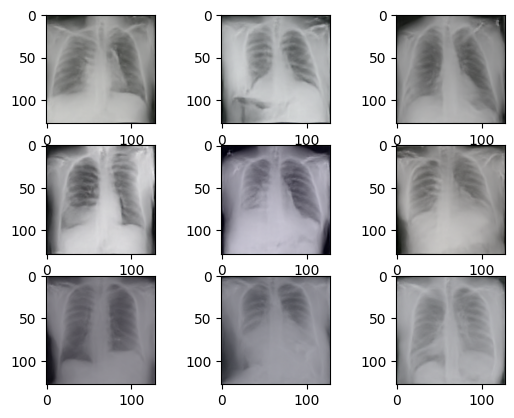

 41%|████      | 41/100 [09:22<14:16, 14.52s/it]

------------------------------


 42%|████▏     | 42/100 [09:35<13:37, 14.10s/it]

------------------------------
train loss epoch: 42: 0.0063
Train Learning Rate EPOCH: 42: 6.525795993546537e-05
------------------------------


 43%|████▎     | 43/100 [09:48<13:07, 13.81s/it]

------------------------------
train loss epoch: 43: 0.0071
Train Learning Rate EPOCH: 43: 6.370608278068e-05
------------------------------


 44%|████▍     | 44/100 [10:01<12:41, 13.60s/it]

------------------------------
train loss epoch: 44: 0.0062
Train Learning Rate EPOCH: 44: 6.213979271825537e-05
------------------------------


 45%|████▌     | 45/100 [10:14<12:20, 13.46s/it]

------------------------------
train loss epoch: 45: 0.0070
Train Learning Rate EPOCH: 45: 6.056073681208038e-05
------------------------------


 46%|████▌     | 46/100 [10:28<12:01, 13.36s/it]

------------------------------
train loss epoch: 46: 0.0062
Train Learning Rate EPOCH: 46: 5.8970575550224206e-05
------------------------------


 47%|████▋     | 47/100 [10:41<11:45, 13.31s/it]

------------------------------
train loss epoch: 47: 0.0090
Train Learning Rate EPOCH: 47: 5.7370981098816725e-05
------------------------------


 48%|████▊     | 48/100 [10:54<11:29, 13.26s/it]

------------------------------
train loss epoch: 48: 0.0073
Train Learning Rate EPOCH: 48: 5.5763635543648377e-05
------------------------------


 49%|████▉     | 49/100 [11:07<11:14, 13.22s/it]

------------------------------
train loss epoch: 49: 0.0066
Train Learning Rate EPOCH: 49: 5.4150229121339036e-05
------------------------------


 50%|█████     | 50/100 [11:20<10:59, 13.19s/it]

------------------------------
train loss epoch: 50: 0.0066
Train Learning Rate EPOCH: 50: 5.2532458441935636e-05
------------------------------


100%|██████████| 32/32 [00:13<00:00,  2.44it/s]


------------------------------
train loss epoch: 51: 0.0060
Train Learning Rate EPOCH: 51: 5.091202470480758e-05



100%|██████████| 100/100 [00:03<00:00, 25.12it/s][A


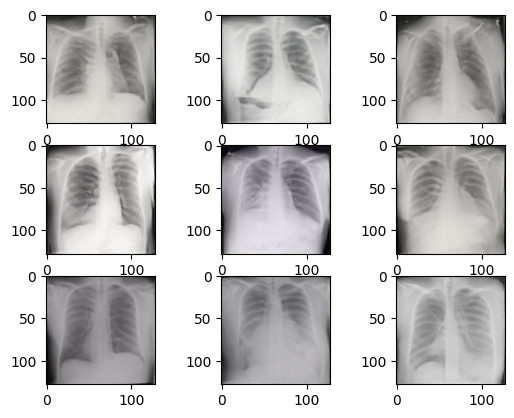

 51%|█████     | 51/100 [11:38<11:53, 14.55s/it]

------------------------------


 52%|█████▏    | 52/100 [11:51<11:18, 14.13s/it]

------------------------------
train loss epoch: 52: 0.0059
Train Learning Rate EPOCH: 52: 4.929063190971633e-05
------------------------------


 53%|█████▎    | 53/100 [12:04<10:49, 13.83s/it]

------------------------------
train loss epoch: 53: 0.0064
Train Learning Rate EPOCH: 53: 4.7669985064940046e-05
------------------------------


 54%|█████▍    | 54/100 [12:17<10:26, 13.62s/it]

------------------------------
train loss epoch: 54: 0.0058
Train Learning Rate EPOCH: 54: 4.605178839433788e-05
------------------------------


 55%|█████▌    | 55/100 [12:30<10:06, 13.47s/it]

------------------------------
train loss epoch: 55: 0.0065
Train Learning Rate EPOCH: 55: 4.443774354523882e-05
------------------------------


 56%|█████▌    | 56/100 [12:44<09:48, 13.38s/it]

------------------------------
train loss epoch: 56: 0.0058
Train Learning Rate EPOCH: 56: 4.2829547799040375e-05
------------------------------


 57%|█████▋    | 57/100 [12:57<09:32, 13.30s/it]

------------------------------
train loss epoch: 57: 0.0081
Train Learning Rate EPOCH: 57: 4.122889228639791e-05
------------------------------


 58%|█████▊    | 58/100 [13:10<09:16, 13.25s/it]

------------------------------
train loss epoch: 58: 0.0068
Train Learning Rate EPOCH: 58: 3.963746020888226e-05
------------------------------


 59%|█████▉    | 59/100 [13:23<09:01, 13.22s/it]

------------------------------
train loss epoch: 59: 0.0063
Train Learning Rate EPOCH: 59: 3.805692506897505e-05
------------------------------


 60%|██████    | 60/100 [13:36<08:47, 13.19s/it]

------------------------------
train loss epoch: 60: 0.0063
Train Learning Rate EPOCH: 60: 3.6488948910263584e-05
------------------------------


100%|██████████| 32/32 [00:13<00:00,  2.44it/s]


------------------------------
train loss epoch: 61: 0.0057
Train Learning Rate EPOCH: 61: 3.4935180569685225e-05



100%|██████████| 100/100 [00:03<00:00, 25.16it/s][A


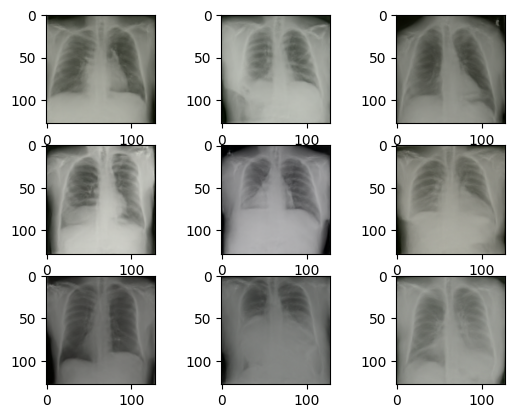

 61%|██████    | 61/100 [13:54<09:27, 14.55s/it]

------------------------------


 62%|██████▏   | 62/100 [14:07<08:56, 14.13s/it]

------------------------------
train loss epoch: 62: 0.0055
Train Learning Rate EPOCH: 62: 3.3397253943659855e-05
------------------------------


 63%|██████▎   | 63/100 [14:20<08:31, 13.83s/it]

------------------------------
train loss epoch: 63: 0.0060
Train Learning Rate EPOCH: 63: 3.187678626993307e-05
------------------------------


 64%|██████▍   | 64/100 [14:33<08:10, 13.62s/it]

------------------------------
train loss epoch: 64: 0.0054
Train Learning Rate EPOCH: 64: 3.0375376426937153e-05
------------------------------


 65%|██████▌   | 65/100 [14:46<07:52, 13.50s/it]

------------------------------
train loss epoch: 65: 0.0061
Train Learning Rate EPOCH: 65: 2.8894603252458408e-05
------------------------------


 66%|██████▌   | 66/100 [15:00<07:35, 13.39s/it]

------------------------------
train loss epoch: 66: 0.0054
Train Learning Rate EPOCH: 66: 2.7436023883378303e-05
------------------------------


 67%|██████▋   | 67/100 [15:13<07:19, 13.31s/it]

------------------------------
train loss epoch: 67: 0.0077
Train Learning Rate EPOCH: 67: 2.6001172118234874e-05
------------------------------


 68%|██████▊   | 68/100 [15:26<07:04, 13.26s/it]

------------------------------
train loss epoch: 68: 0.0065
Train Learning Rate EPOCH: 68: 2.4591556804325898e-05
------------------------------


 69%|██████▉   | 69/100 [15:39<06:49, 13.22s/it]

------------------------------
train loss epoch: 69: 0.0059
Train Learning Rate EPOCH: 69: 2.3208660251050158e-05
------------------------------


 70%|███████   | 70/100 [15:52<06:35, 13.20s/it]

------------------------------
train loss epoch: 70: 0.0058
Train Learning Rate EPOCH: 70: 2.1853936671155127e-05
------------------------------


100%|██████████| 32/32 [00:13<00:00,  2.44it/s]


------------------------------
train loss epoch: 71: 0.0053
Train Learning Rate EPOCH: 71: 2.052881065153009e-05



100%|██████████| 100/100 [00:03<00:00, 25.14it/s][A


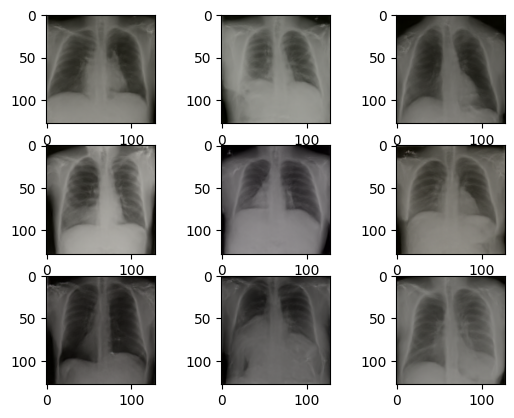

 71%|███████   | 71/100 [16:10<07:02, 14.56s/it]

------------------------------


 72%|███████▏  | 72/100 [16:23<06:35, 14.13s/it]

------------------------------
train loss epoch: 72: 0.0052
Train Learning Rate EPOCH: 72: 1.9234675655153333e-05
------------------------------


 73%|███████▎  | 73/100 [16:36<06:13, 13.83s/it]

------------------------------
train loss epoch: 73: 0.0056
Train Learning Rate EPOCH: 73: 1.7972892555767773e-05
------------------------------


 74%|███████▍  | 74/100 [16:49<05:54, 13.64s/it]

------------------------------
train loss epoch: 74: 0.0050
Train Learning Rate EPOCH: 74: 1.6744788206827038e-05
------------------------------


 75%|███████▌  | 75/100 [17:02<05:37, 13.49s/it]

------------------------------
train loss epoch: 75: 0.0057
Train Learning Rate EPOCH: 75: 1.555165404621567e-05
------------------------------


 76%|███████▌  | 76/100 [17:16<05:21, 13.38s/it]

------------------------------
train loss epoch: 76: 0.0051
Train Learning Rate EPOCH: 76: 1.439474473821188e-05
------------------------------


 77%|███████▋  | 77/100 [17:29<05:05, 13.30s/it]

------------------------------
train loss epoch: 77: 0.0072
Train Learning Rate EPOCH: 77: 1.3275276854119739e-05
------------------------------


 78%|███████▊  | 78/100 [17:42<04:51, 13.25s/it]

------------------------------
train loss epoch: 78: 0.0059
Train Learning Rate EPOCH: 78: 1.2194427592959389e-05
------------------------------


 79%|███████▉  | 79/100 [17:55<04:37, 13.22s/it]

------------------------------
train loss epoch: 79: 0.0055
Train Learning Rate EPOCH: 79: 1.1153333543559452e-05
------------------------------


 80%|████████  | 80/100 [18:08<04:23, 13.19s/it]

------------------------------
train loss epoch: 80: 0.0055
Train Learning Rate EPOCH: 80: 1.0153089489354257e-05
------------------------------


100%|██████████| 32/32 [00:13<00:00,  2.44it/s]


------------------------------
train loss epoch: 81: 0.0050
Train Learning Rate EPOCH: 81: 9.194747257142212e-06



100%|██████████| 100/100 [00:03<00:00, 25.14it/s][A


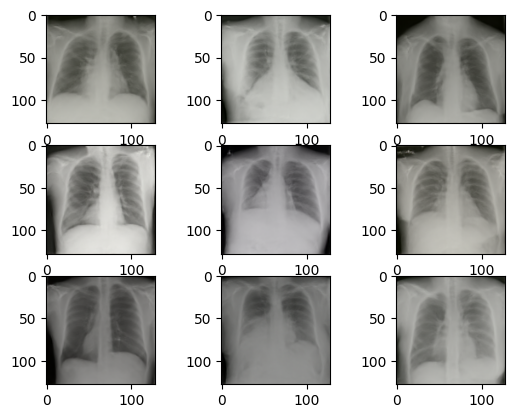

 81%|████████  | 81/100 [18:26<04:36, 14.55s/it]

------------------------------


 82%|████████▏ | 82/100 [18:39<04:14, 14.12s/it]

------------------------------
train loss epoch: 82: 0.0049
Train Learning Rate EPOCH: 82: 8.279314611016148e-06
------------------------------


 83%|████████▎ | 83/100 [18:52<03:55, 13.84s/it]

------------------------------
train loss epoch: 83: 0.0053
Train Learning Rate EPOCH: 83: 7.407754192628657e-06
------------------------------


 84%|████████▍ | 84/100 [19:05<03:38, 13.63s/it]

------------------------------
train loss epoch: 84: 0.0047
Train Learning Rate EPOCH: 84: 6.580982508906852e-06
------------------------------


 85%|████████▌ | 85/100 [19:18<03:22, 13.48s/it]

------------------------------
train loss epoch: 85: 0.0054
Train Learning Rate EPOCH: 85: 5.7998689682810746e-06
------------------------------


 86%|████████▌ | 86/100 [19:31<03:07, 13.38s/it]

------------------------------
train loss epoch: 86: 0.0048
Train Learning Rate EPOCH: 86: 5.065234966440885e-06
------------------------------


 87%|████████▋ | 87/100 [19:45<02:52, 13.31s/it]

------------------------------
train loss epoch: 87: 0.0068
Train Learning Rate EPOCH: 87: 4.3778530225798755e-06
------------------------------


 88%|████████▊ | 88/100 [19:58<02:39, 13.25s/it]

------------------------------
train loss epoch: 88: 0.0056
Train Learning Rate EPOCH: 88: 3.7384459670375626e-06
------------------------------


 89%|████████▉ | 89/100 [20:11<02:25, 13.22s/it]

------------------------------
train loss epoch: 89: 0.0052
Train Learning Rate EPOCH: 89: 3.1476861811925553e-06
------------------------------


 90%|█████████ | 90/100 [20:24<02:11, 13.19s/it]

------------------------------
train loss epoch: 90: 0.0052
Train Learning Rate EPOCH: 90: 2.606194890406366e-06
------------------------------


100%|██████████| 32/32 [00:13<00:00,  2.43it/s]


------------------------------
train loss epoch: 91: 0.0048
Train Learning Rate EPOCH: 91: 2.11454151076137e-06



100%|██████████| 100/100 [00:03<00:00, 25.11it/s][A


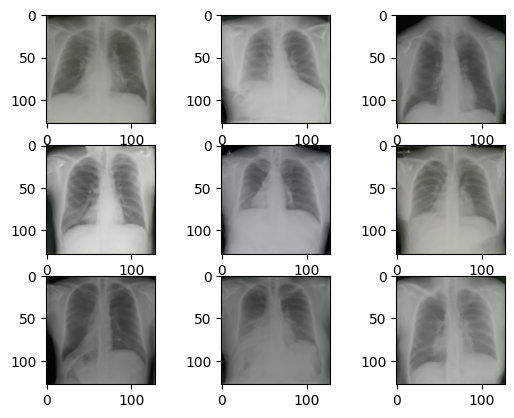

 91%|█████████ | 91/100 [20:42<02:11, 14.67s/it]

------------------------------


 92%|█████████▏| 92/100 [20:55<01:53, 14.20s/it]

------------------------------
train loss epoch: 92: 0.0047
Train Learning Rate EPOCH: 92: 1.6732430502798157e-06
------------------------------


 93%|█████████▎| 93/100 [21:08<01:37, 13.88s/it]

------------------------------
train loss epoch: 93: 0.0050
Train Learning Rate EPOCH: 93: 1.2827635652536473e-06
------------------------------


 94%|█████████▍| 94/100 [21:21<01:21, 13.65s/it]

------------------------------
train loss epoch: 94: 0.0045
Train Learning Rate EPOCH: 94: 9.435136722567405e-07
------------------------------


 95%|█████████▌| 95/100 [21:35<01:07, 13.49s/it]

------------------------------
train loss epoch: 95: 0.0052
Train Learning Rate EPOCH: 95: 6.558501163527964e-07
------------------------------


 96%|█████████▌| 96/100 [21:48<00:53, 13.38s/it]

------------------------------
train loss epoch: 96: 0.0047
Train Learning Rate EPOCH: 96: 4.2007539595280143e-07
------------------------------


 97%|█████████▋| 97/100 [22:01<00:39, 13.30s/it]

------------------------------
train loss epoch: 97: 0.0066
Train Learning Rate EPOCH: 97: 2.364374447168305e-07
------------------------------


 98%|█████████▊| 98/100 [22:14<00:26, 13.26s/it]

------------------------------
train loss epoch: 98: 0.0054
Train Learning Rate EPOCH: 98: 1.0512937083432262e-07
------------------------------


 99%|█████████▉| 99/100 [22:27<00:13, 13.23s/it]

------------------------------
train loss epoch: 99: 0.0051
Train Learning Rate EPOCH: 99: 2.628925395731785e-08
------------------------------


100%|██████████| 100/100 [22:40<00:00, 13.61s/it]

------------------------------
train loss epoch: 100: 0.0051
Train Learning Rate EPOCH: 100: 0.0
------------------------------


In [68]:
from diffusers.optimization import get_cosine_schedule_with_warmup
from accelerate import Accelerator
from tqdm import tqdm

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=(len(train_loader) * NUM_EPOCHS)
)

accelerator = Accelerator(
    mixed_precision=MIXED_PRECISION,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS
)

model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(model, optimizer, train_loader, lr_scheduler)

start = timeit.default_timer()
for epoch in tqdm(range(NUM_EPOCHS), position=0, leave=True):
    model.train()
    train_running_loss=0
    for idx, batch in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        clean_images=batch[0].to(device)
        noise = torch.randn(clean_images.shape).to(device)
        last_batch_size=len(clean_images)

        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (last_batch_size,)).to(device)
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        with accelerator.accumulate(model):
            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
            loss = F.mse_loss(noise_pred, noise)
            accelerator.backward(loss)

            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            
        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx+1)

    train_learning_rate = lr_scheduler.get_last_lr()[0]
    print("-"*30)
    print(f"train loss epoch: {epoch+1}: {train_loss:.4f}")
    print(f"Train Learning Rate EPOCH: {epoch+1}: {train_learning_rate}")
    if epoch%10 == 0:
        sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, NUM_TIMESTEPS)
    print("-"*30)